# **<center><font style="color:rgb(100,109,254)">Module 2: Real-Time Controllable Face Makeup</font> </center>**

<img src='https://drive.google.com/uc?export=download&id=1ERLn4WIEsSGnAO_4LDT8R8FTf6ac3f5n'>

## **<font style="color:rgb(134,19,348)"> Module Outline </font>**

The module can be split into the following parts:

- *Lesson 1: Introduction to Face Landmark Detection Theory*

- *Lesson 2: Create a Face Landmarks Detector*

- *Lesson 3: Build a Face Part Selector*

- ***Lesson 4:* Build a Virtual Face Makeup Application** *(This Tutorial)*

- *Lesson 5: Build the Final Application*

**Please Note**, these Jupyter Notebooks are not for sharing; do read the Copyright message below the Code License Agreement section which is in the last cell of this notebook.
-Taha Anwar

Alright, let's get started.

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

First, we will import the required libraries.

In [1]:
import cv2
import itertools
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from previous_lesson import detectFacialLandmarks
from importlib.metadata import version
print(f"Mediapipe version: {version('mediapipe')}, it should be 0.8.9.1")

Mediapipe version: 0.8.10.1, it should be 0.8.9.1


## **<font style="color:rgb(134,19,348)">Initialize the Face Landmarks Detection Model</font>**

After that, we will initialize the **`mp.solutions.face_mesh`** class and set up the **`mp.solutions.face_mesh.FaceMesh()`** function (for images and videos as well) with appropriate arguments as we have been doing in the previous lessons.

In [2]:
# Initialize the mediapipe face mesh class.
mp_face_mesh = mp.solutions.face_mesh

# Set up the face landmarks function for images.
face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=2,
                                         refine_landmarks=True, min_detection_confidence=0.5)

# Set up the face landmarks function for videos.
face_mesh_videos = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, 
                                         refine_landmarks=True, min_detection_confidence=0.5,
                                         min_tracking_confidence=0.3)

## **<font style="color:rgb(134,19,348)">Initialize the Face Parts Indexes</font>**

Now we will initialize a few lists containing the indexes of landmarks of the face parts we need to isolate, in order to apply virtual foundation, lipstick, and eyeliner on the faces in images/videos.

<center>
    
<img src='https://drive.google.com/uc?export=download&id=1wOuAzZfXKJ1OZhE94PqGbv4ab1fPEZJy' width = 600> <br>
<a href="https://developers.google.com/ar/develop/augmented-faces">Image Source</a>

</center>

In [3]:
# Initialize a list to store the indexes of the upper lips outer outline landmarks.
lips_upper_outer_ids = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291]

# Initialize a list to store the indexes of the lower lips outer outline landmarks.
lips_lower_outer_ids = [61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291]

# Initialize a list to store the indexes of the upper lips inner outline landmarks.
lips_upper_inner_ids = [78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308]

# Initialize a list to store the indexes of the lower lips inner outline landmarks.
lips_lower_inner_ids = [324, 318, 402, 317, 14, 87, 178, 88, 95, 78]

# Initialize a list to store the indexes of the upper part of the left eye outline landmarks.
left_eye_upper_ids = [246, 161, 160, 159, 158, 157, 173]

# Initialize a list to store the indexes of the lower part of the left eye outline landmarks.
left_eye_lower_ids = [133, 155, 154, 153, 145, 144, 163, 7, 33]

# Initialize a list to store the indexes of the upper part of the right eye outline landmarks.
right_eye_upper_ids=[466, 388, 387, 386, 385, 384, 398]

# Initialize a list to store the indexes of the lower part of the right eye outline landmarks.
right_eye_lower_ids=[362, 382, 381, 380, 374, 373, 390, 249, 263]


# For homework, eyebrow landmarks
# Initialize a list to store the indexes of the upper part of the right eye outline landmarks.
# Updated the list of indexes for the upper landmarks of the eyebrows
right_eyebrow_upper_ids = [293, 334, 296, 336]
right_eyebrow_lower_ids = [285, 295, 282, 283, 276]

left_eyebrow_upper_ids = [63, 105, 66, 107]
left_eyebrow_lower_ids = [55, 65, 52, 53, 46]

## **<font style="color:rgb(134,19,348)">Create a Function to Get Face Parts Mask</font>**

After the initializations, now we will create a function **`getFacePartMask()`** that will utilize the facial landmarks returned by the Face Landmarks Detection Model and the lists of indexes we had initialized, to generate face parts masks (with pixel values `255` at the face part region and `0` at the remaining regions) images, required to determine the locations to apply virtual makeup in images/video. 

Note that in **`getFacePartMask()`**, we have used the [**`cv2.convexHull()`**](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga014b28e56cb8854c0de4a211cb2be656) function to get the face outline landmarks indexes, we could have manually defined a list of indexes for the face too but I wanted to teach you this approach, but of course, this method will not work for the face parts like the lips as we need outer border and inner border landmarks indexes as well to differentiate lips and mouth and apply lipstick appropriately. So as I mentioned in the previous lesson, there is a trade-off of control and manual effort that you must always keep in mind while deciding an approach well-suited for your use case. 

To generate the mask image, we will first create an empty `canvas` *(i.e. just an empty black image)* and then utilize the [**`cv2.drawContours()`**](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc) function and the face parts landmarks to draw the required face parts on the mask image. Below you can see how the generated mask images for the foundation, lipstick, and eyeliner look like.

<center><img src='https://drive.google.com/uc?export=download&id=1DY3nCZT5vXBlwiVs829OKs_IUUCwa9OH'></center>

In [4]:
def getFacePartMask(image, face_landmarks, face_part='FACE',  display=True):
    '''
    This function will generate a face part mask image utilizing face landmarks.
    Args:
        image:          The image of the face whose face part mask image is required.
        face_landmarks: An array containing the face landmarks (x and y coordinates) of the face in the image.
        face_part:      The face part name whose mask is to be generated.
        display:        A boolean value that is if set to true the function displays the face image, 
                        and the generated face part mask image and returns nothing.
    Returns:
        mask: The face part mask image with values 255 at the specified face part region and 0 at the remaining regions.
    '''
    
    # Get the height and width of the face image.
    height, width, _ = image.shape
    
    # Initialize a list to store the face outline landmarks.
    face_outline_landmarks = []
    
    # Initialize a list to store the lips landmarks.
    lips_landmarks = []
    
    # Initialize a list to store the mouth landmarks.
    mouth_landmarks= []
    
    # Initialize a list to store the left eye landmarks.
    left_eye_landmarks = []
    
    # Initialize a list to store the right eye landmarks.
    right_eye_landmarks = []

    # For homework, eyebrow landmarks
    right_eyebrow_landmarks = []
    left_eyebrow_landmarks = []
    
    # Find Convex hull of the face landmarks.
    # Convex hull is the smallest convex set of points (boundary) that contains all the points in it.
    # This will return the indexes of the face outline landmarks.
    face_outline_indexes = cv2.convexHull(face_landmarks, returnPoints=False)

    # Iterate over the indexes of the face outline.   
    for index in face_outline_indexes:

        # Get the landmark at the index we are iterating upon,
        # And append it into the list.
        face_outline_landmarks.append(face_landmarks[index[0]])
    
    # Iterate over the indexes of the upper and lower lips outer outline.
    for index in lips_upper_outer_ids+lips_lower_outer_ids:
        
        # Get the landmark at the index we are iterating upon,
        # And append it into the list.
        lips_landmarks.append(face_landmarks[index])
    
    # Iterate over the indexes of the upper and lower lips innner outline.   
    for index in lips_upper_inner_ids+lips_lower_inner_ids:
        
        # Get the landmark at the index we are iterating upon,
        # And append it into the list.
        mouth_landmarks.append(face_landmarks[index])
    
    # Iterate over the indexes of the left eye outline.
    for index in left_eye_upper_ids+left_eye_lower_ids:
        
        # Get the landmark at the index we are iterating upon,
        # And append it into the list.
        left_eye_landmarks.append(face_landmarks[index])
        
    # Iterate over the indexes of the right eye outline.
    for index in right_eye_upper_ids+right_eye_lower_ids:
        
        # Get the landmark at the index we are iterating upon,
        # And append it into the list.
        right_eye_landmarks.append(face_landmarks[index])

    
    # CHALLENGE PART
    # Right Eyebrow
    for index in right_eyebrow_upper_ids+right_eyebrow_lower_ids:
        # Get the landmark at the index we are iterating upon,
        # And append it into the list.
        right_eyebrow_landmarks.append(face_landmarks[index])
    
    # Left Eyebrow
    for index in left_eyebrow_upper_ids+left_eyebrow_lower_ids:
        
        # Get the landmark at the index we are iterating upon,
        # And append it into the list.
        left_eyebrow_landmarks.append(face_landmarks[index])

    # Initialize a black empty canvas to draw the face part(s) on.
    mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Check if the specified face part whose mask is needed is the FACE.
    if face_part == 'FACE':
        
        # Draw (white) filled face contours on the mask (black canvas).
        cv2.drawContours(mask, contours=[np.int32(face_outline_landmarks)], contourIdx=-1, 
                             color=(255, 255, 255), thickness=-1)  

        # Remove right eye area from the mask by drawing filled right eye contours with black color.
        cv2.drawContours(mask, contours=[np.array(right_eye_landmarks, np.int32)], contourIdx=-1, 
                         color=(0, 0, 0), thickness=-1)
        
        # Remove left eye area from the mask by drawing filled left eye contours with black color.
        cv2.drawContours(mask, contours=[np.array(left_eye_landmarks, np.int32)], contourIdx=-1, 
                         color=(0, 0, 0), thickness=-1) 
        
        # Remove lips area from the mask by drawing filled lips contours with black color.
        cv2.drawContours(mask, contours=[np.array(lips_landmarks, np.int32)], contourIdx=-1, 
                         color=(0, 0, 0), thickness=-1)
    
    # Check if the specified face part whose mask is needed is the LIPS.
    elif face_part == 'LIPS':
        
        # Draw (white) filled lips contours on the mask (black canvas).
        cv2.drawContours(mask, contours=[np.int32(lips_landmarks)], contourIdx=-1, 
                         color=(255, 255, 255), thickness=-1)  
    
        # Remove mouth area from the mask by drawing filled mouth contours with black color.
        cv2.drawContours(mask, contours=[np.array(mouth_landmarks, np.int32)], contourIdx=-1, 
                         color=(0, 0, 0), thickness=-1)    
        
    # Check if the specified face part whose mask is needed is the EYES.
    elif face_part == 'EYES':
        
        # Draw (white) hollow right eye contours on the mask (black canvas) with thickness 2.
        cv2.drawContours(mask, contours=[np.int32(right_eye_landmarks)], contourIdx=-1, 
                         color=(255, 255, 255), thickness=2) 
        
        # Draw (white) hollow left eye contours on the mask (black canvas) with thickness 2.
        cv2.drawContours(mask, contours=[np.int32(left_eye_landmarks)], contourIdx=-1, 
                     color=(255, 255, 255), thickness=2)
    
    # Check if the specified face part whose mask is needed is the EYES.
    elif face_part == 'EYEBROWS':
        
        # Draw (white) hollow right eye contours on the mask (black canvas) with thickness 2.
        cv2.drawContours(mask, contours=[np.int32(right_eyebrow_landmarks)], contourIdx=-1, 
                         color=(255, 255, 255), thickness=12) 
        
        # Draw (white) hollow left eye contours on the mask (black canvas) with thickness 2.
        cv2.drawContours(mask, contours=[np.int32(left_eyebrow_landmarks)], contourIdx=-1, 
                     color=(255, 255, 255), thickness=12)

        
    # Check if the original input image and the generated mask image are specified to be displayed.
    if display:
        
        # Display the original input image and the generated mask image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Sample Image");plt.axis('off');
        plt.subplot(122);plt.imshow(mask);plt.title("Output Image");plt.axis('off');
        
    # Otherwise
    else: 
    
        # Return the face part mask image with values 255 at the specified face part region.
        return mask

Now let's test the **`getFacePartMask()`** function created above, on a few sample images and visualize the results.

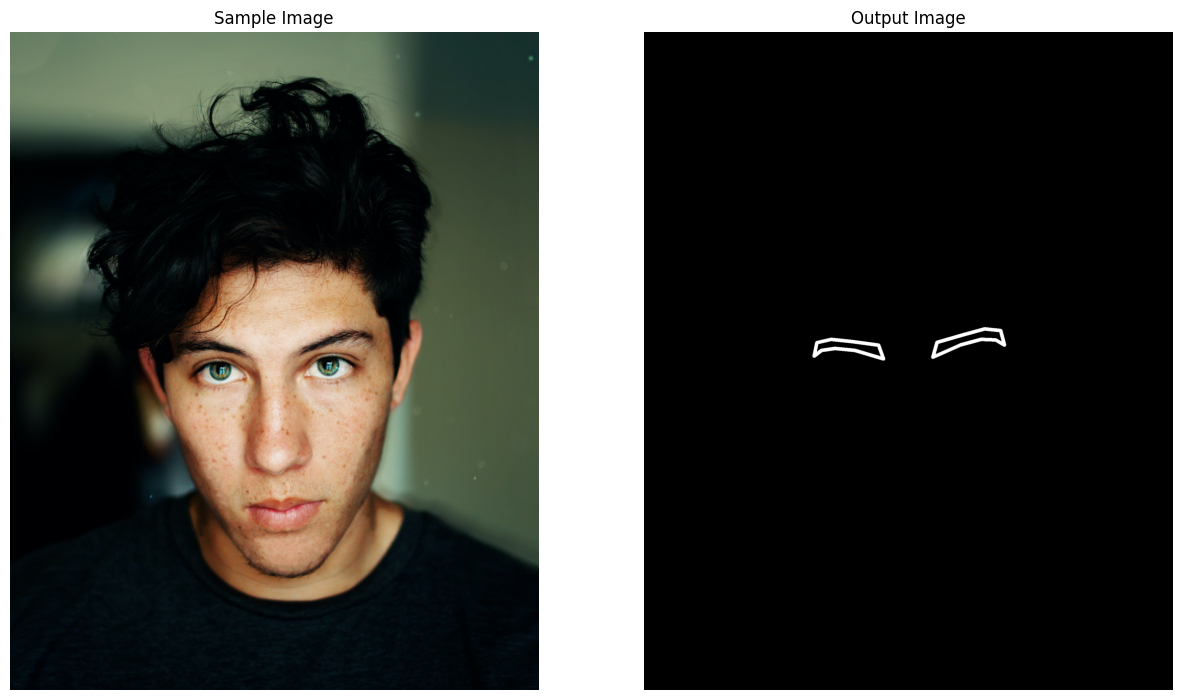

In [5]:
# Read a sample image and extract foundation mask of the face in the image.
image = cv2.imread('media/sample4.jpg')
image, face_landmarks = detectFacialLandmarks(image, face_mesh_images, draw=False, display=False)
getFacePartMask(image, face_landmarks, face_part='EYEBROWS')

In [6]:
# Read another sample image and extract lipstick mask of the face in the image.
image = cv2.imread('media/sample5.jpg')
image, face_landmarks = detectFacialLandmarks(image, face_mesh_images, draw=False, display=False)
getFacePartMask(image, face_landmarks, face_part='EYEBROWS')

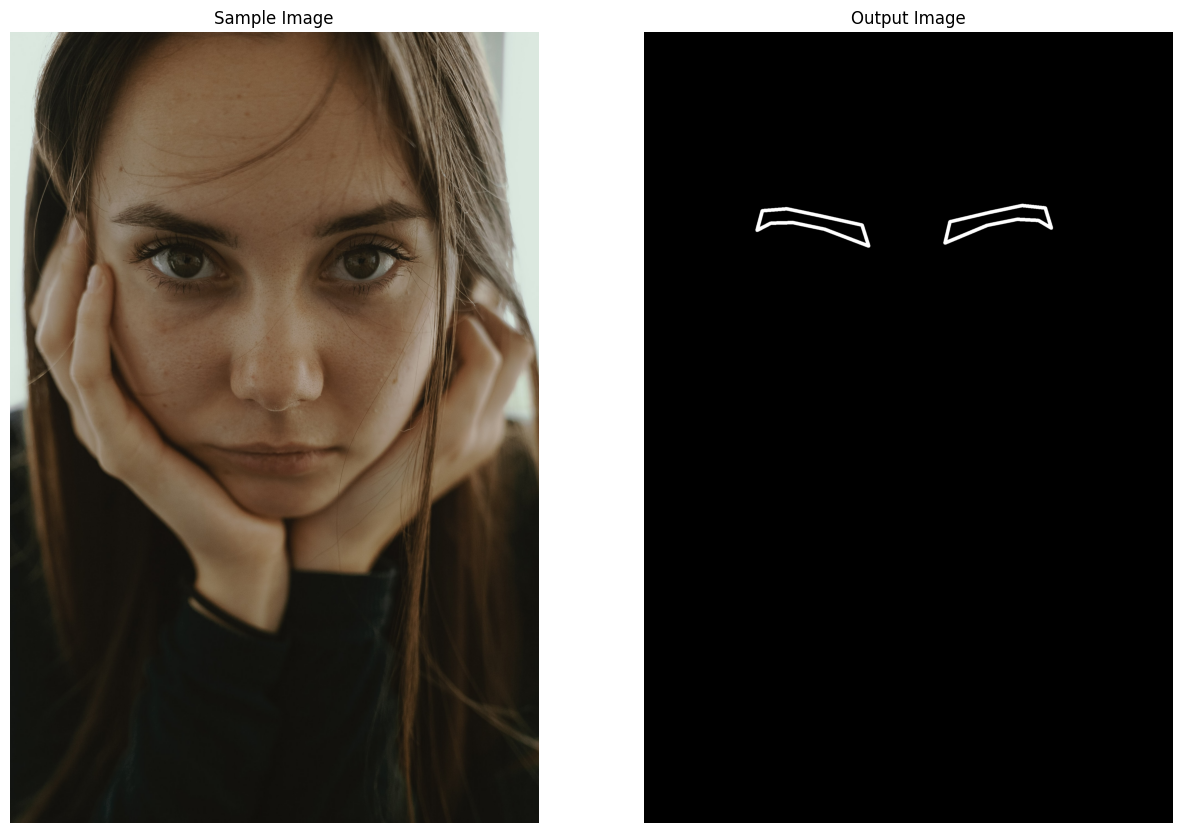

In [7]:
# Read another sample image and extract eyeliner mask of the face in the image.
image = cv2.imread('media/sample6.jpg')
image, face_landmarks = detectFacialLandmarks(image, face_mesh_images, draw=False, display=False)
getFacePartMask(image, face_landmarks, face_part='EYEBROWS')

Great! its accurately generating the masks for each face part. A fancier way to go around this, could be to generate a single mask with each face part having different colors. Somthing like this:

<center>
    <img src='https://drive.google.com/uc?export=download&id=1ZAQh3BPJQoDJ--L1TZoEYNtomgKAQftU' width = 600> <br>
    <a href="https://github.com/shaoanlu/face_toolbox_keras">Image Source</a>
</center>
    
But for the sake of simplicity, we are just gonna stay with the white color.

## **<font style="color:rgb(134,19,348)">Create a Function to Apply Virtual Face Makeup</font>**

Now we will move on to the main course that is creating a function **`applyMakeup()`** to apply Virtual Foundation, Lipstick, and Eyeliner on faces by modifying the hue, saturation, and values channels of the images and videos. In the previous module, we had done something similar for the whole image but in this one, we will only change the HSV values of the regions on which we want to apply virtual makeup. 

In the function **`applyMakeup()`**, we will first crop the face regions (to apply makeup on) from an image/frame utilizing the generated face part mask image. For which, we will use the [**`cv2.findContours()`**](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a) function on the face part mask image to get the face part(s) contours (boundary) and then pass those contours to the  [**`cv2.boundingRect()`**](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga103fcbda2f540f3ef1c042d6a9b35ac7) function to get the rectangular region coordinates (enclosing the face part) required to crop the face regions. And then we will change HSV values of the cropped region using a helper function **`changeHSV()`** to get the virtual makeup effect. 

After that, We will simply update the pixel values of the original image with the modified (HSV values) image at the face part(s) regions utilizing the face part(s) mask. We could skip the cropping part and modify a complete copy of the image and then update the pixel values at the face part(s) regions and still get the same results but the cropping part makes the whole process very efficient.


<center><img src='https://drive.google.com/uc?export=download&id=11BstsSJ3GYj8Yk93kwlQDIGi-DeaTapO'></center>

In [8]:
def applyMakeup(image, face_part_mask, hsv_value, display=True):
    '''
    This function will apply virtual makeup (like foundation, lipstick, and eyeliner) on a face.
    Args:
        image:          The image to apply virtual face makeup on.
        face_part_mask: The mask image of the face part on which to apply virtual makeup on. 
        hsv_value:      A list containing hue, saturation, and value channel scale factors.
        display:        A boolean value that is if set to true the function displays the original input image, 
                        and the output image with the virtual face makeup applied and returns nothing.
    Returns: 
        output_image: A copy of the input image with the virtual face makeup applied. 
    '''
    
    # Define a helper nested function to modify hue, saturation, and value channels.
    # We are defining it inside this function scope because we need this changeHSV() function only here.
    def changeHSV(input_image, hsv_scale_factor):
        '''
        This function will increase/decrease the Hue, Saturation, and Value (Brighness) channels of an image.
        Args:
            image:            The image whose Hue, Saturation, and Value channels are to be modified.
            hsv_scale_factor: A list containing hue, saturation, and value channels scale factors.
        Returns:
            output_image: A copy of the input image with the Hue, Saturation, and Value channels modified.
        '''
        
        # Get the hue, saturation, and value channels scale factors.
        hue_scale, saturation_scale, value_scale = hsv_scale_factor

        # Conver the image from BGR into HSV format.
        image_hsv = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV)

        # Convert the pixel values of the image into float.
        image_hsv = np.array(image_hsv, dtype=np.float64)

        # Split the hue, saturation, and value channel of the image.
        hue_channel, saturation_channel, value_channel = cv2.split(image_hsv)
        
        # Scale up or down the pixel values of the hue channel accordingly to the scale factor.
        # This np.mod() function will keep the resultant values between [0-179].
        # As in opencv, hue channel only have values between [0-179].
        hue_channel = np.mod(hue_channel+hue_scale, 180)

        # Scale up or down the pixel values of the saturation channel accordingly the scale factor.
        saturation_channel *= saturation_scale

        # Scale up or down the pixel values of the value channel accordingly the scale factor.
        value_channel *= value_scale

        # Merge the Hue, Saturation, and Value channel.
        image_hsv = cv2.merge((hue_channel, saturation_channel, value_channel))

        # Set values > 255 to 255 and values < 0 to 0.
        image_hsv[image_hsv > 255] = 255
        image_hsv[image_hsv < 0] = 0

        # Convert the image into uint8 type and BGR format.
        output_image = cv2.cvtColor(np.array(image_hsv, dtype=np.uint8), cv2.COLOR_HSV2BGR)

        # Return the output image with the Hue, Saturation, and Value channels values modified.
        return output_image
    
    # Create copies of the input image.
    output_image = image.copy()
    modified_image = image.copy()
    
    # Get the face part(s) contours from the face part mask image.
    # cv2.findContours() requires a single channel image, so we will only pass the first channel of the mask image.
    contours, _ = cv2.findContours(image=face_part_mask[:,:,0], mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    
    # Iterate over the found contours.
    for cnt in contours:
        
        # Get the bounding box (enclosing a face part) coordinates.
        x1, y1, width, height = cv2.boundingRect(cnt)
        
        # Calculate the bounding box x2 and y2 values utilizing the x1, y1, width, height values.
        x2, y2 = x1+width, y1+height
        
        # Crop the face part region from a copy of the image.
        image_roi = modified_image[y1:y2, x1:x2]
        
        # Modify the Hue, Saturation, and Value (Brighness) channels of the cropped image.
        modified_roi = changeHSV(image_roi, hsv_value)
        
        # Apply bilateral filter to smoothen the cropped image.
        modified_roi = cv2.bilateralFilter(src=modified_roi, d=5, sigmaColor=4, sigmaSpace=4)
        
        # Put back the cropped modified part into the copy of the image.
        modified_image[y1:y2, x1:x2] = modified_roi
    
    # Update the pixel values of the output image with the modified image values at the indexes,
    # where face_part_mask!=0 i.e. where mask is not black and face parts are drawn there. 
    output_image[np.mean(face_part_mask, axis=2)!=0] = modified_image[np.mean(face_part_mask, axis=2)!=0]
    
    # Check if the original input image and the output image are specified to be displayed.
    if display:
        
        # Display the original input image and the output image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Sample Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    # Otherwise
    else:
        
        # Return the output image with the virtual face makeup applied.
        return output_image

Now let's try to apply foundation, lipstick, and eyeliner on a few sample images utilizing the function **`applyMakeup()`**.

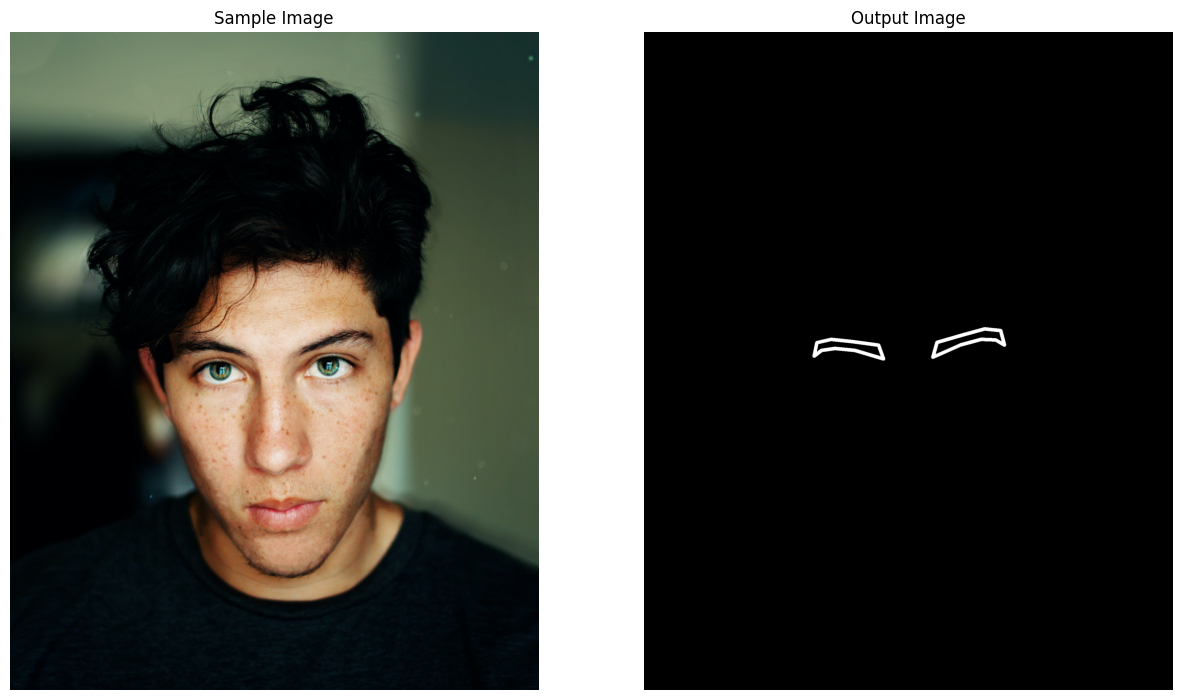

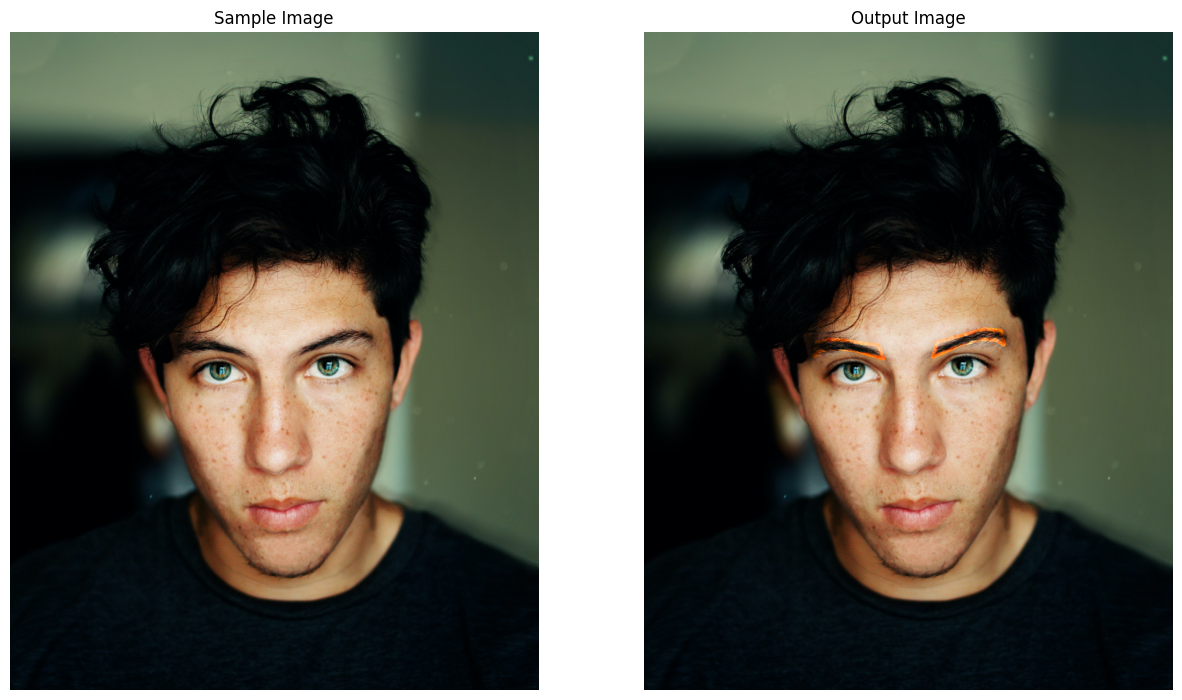

In [9]:
# Read a sample image and apply foundation makeup on the face in the image.
image = cv2.imread('media/sample4.jpg')
image, face_landmarks = detectFacialLandmarks(image, face_mesh_images, draw=False, display=False)
#face_mask = getFacePartMask(image, face_landmarks, face_part='FACE', display=False)
#applyMakeup(image, face_mask, [1,1.4,1.1])

# FOR EYEBROW CHALLENGE
getFacePartMask(image, face_landmarks, face_part="EYEBROWS" )
face_mask = getFacePartMask(image, face_landmarks, face_part='EYEBROWS' , display=False)
# applyMakeup( image, face part, [hue, saturation, and value channels scale factors] )
applyMakeup(image, face_mask, [1.9,1.9,1.9])

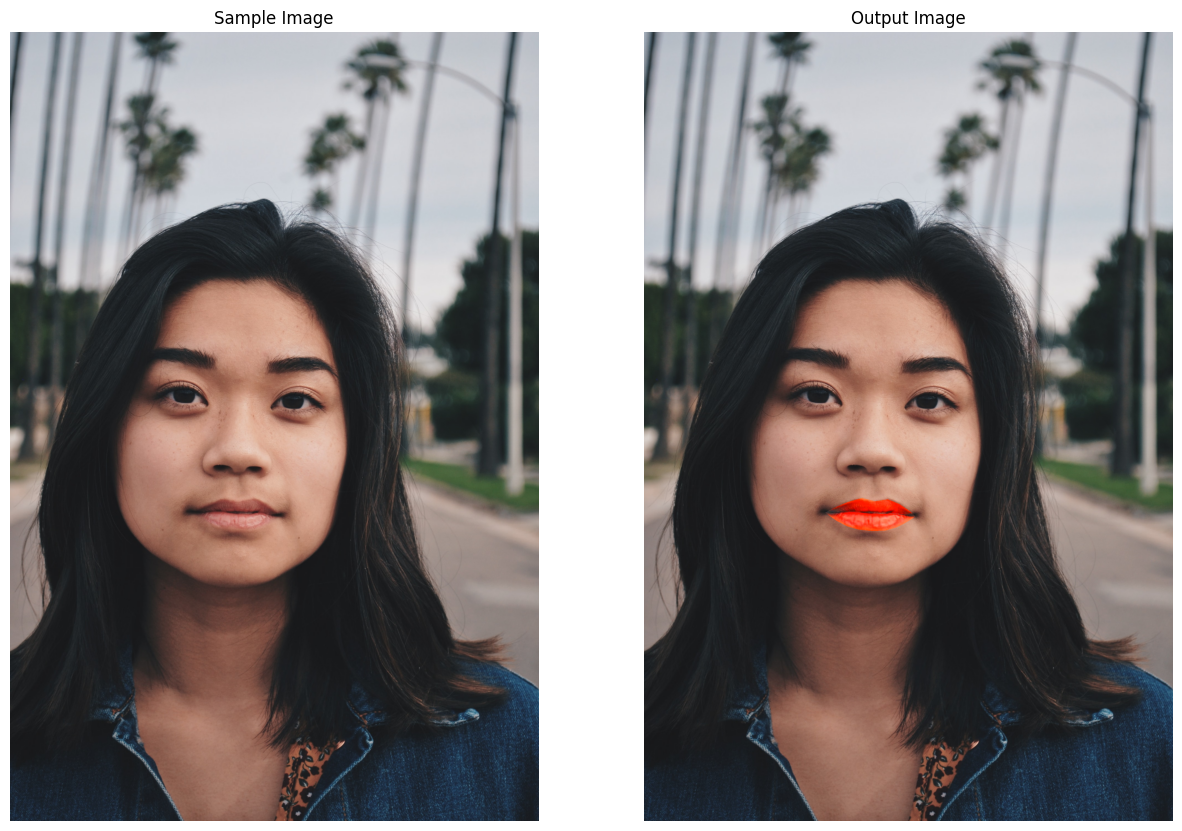

In [10]:
# Read a sample image and apply lipstick on the face in the image.
image = cv2.imread('media/sample5.jpg')
image, face_landmarks = detectFacialLandmarks(image, face_mesh_images, draw=False, display=False)
lips_mask = getFacePartMask(image, face_landmarks, face_part='LIPS', display=False)
applyMakeup(image, lips_mask, [1.9,1.9,1.9])

In [11]:
# Read a sample image and apply eyeliner on the face in the image.
image = cv2.imread('media/sample6.jpg')
image, face_landmarks = detectFacialLandmarks(image, face_mesh_images, draw=False, display=False)
eyes_mask = getFacePartMask(image, face_landmarks, face_part='EYEBROWS', display=False)
applyMakeup(image, eyes_mask, [1,1,0])

Fascinating! Working even better than expected on images. Now let's see how it goes on a real-time webcam feed.

In [12]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0, cv2.CAP_DSHOW)


# Create named window for resizing purposes.
cv2.namedWindow('Virtual Face Makeup', cv2.WINDOW_NORMAL)

# Initialize the face hue, saturation, and value channel scale factors.
face_hsv_value = [1,1.3,1.1]

# Initialize the lips hue, saturation, and value channel scale factors.
lips_hsv_value = [0,1.6,1.1]

# Initialize the eyes hue, saturation, and value channel scale factors.
eyes_hsv_value = [1,1,0]

# Initialize the eyes hue, saturation, and value channel scale factors.
eyebrows_hsv_value = [1,1,0]

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then 
    # continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Perform Face landmarks detection.
    frame, face_landmarks = detectFacialLandmarks(frame, face_mesh_videos, draw=False, display=False)
    
    # Check if the Face landmarks in the frame are detected.
    if len(face_landmarks)>0:
        
        # Extract the foundation mask of the face in the frame.
        face_mask = getFacePartMask(frame, face_landmarks, face_part='FACE', display=False)
        
        # Extract the lipstick mask of the face in the frame.
        lips_mask = getFacePartMask(frame, face_landmarks, face_part='LIPS', display=False)
        
        # Extract the eyeliner mask of the face in the frame.
        eyes_mask = getFacePartMask(frame, face_landmarks, face_part='EYES', display=False)

        # Extract the eyeliner mask of the face in the frame.
        eyebrows_mask = getFacePartMask(frame, face_landmarks, face_part='EYEBROWS', display=False)
        
        # Apply the virtual foundation makeup on the face in the frame.
        frame = applyMakeup(frame, face_mask, face_hsv_value, display=False)
        
        # Apply the virtual lipstick on the face in the frame.
        frame = applyMakeup(frame, lips_mask, lips_hsv_value, display=False)
        
        # Apply the virtual eyeliner on the face in the frame.
        frame = applyMakeup(frame, eyes_mask, eyes_hsv_value, display=False)
        # Apply the virtual eyeliner on the face in the frame.
        frame = applyMakeup(frame, eyebrows_mask, eyebrows_hsv_value, display=False)
        
    # Display the frame.
    cv2.imshow('Virtual Face Makeup', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF    
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.                  
camera_video.release()
cv2.destroyAllWindows()

Cool! working perfectly on videos as well.

##  <font style="color:rgb(34,169,134)">Challenge (Optional)</font>

Change the Eyebrows' color and apply eye shadow on the upper eyes lids utilizing the indexes that you had found in the previous challenge to select these face parts and share the results in the discussion Forum.

<center><img src='https://i.pinimg.com/564x/c1/a7/4f/c1a74f8bedd0abc8a18c1c8df7cb24ac.jpg'>

[Image Credit](https://www.pinterest.com/pin/143130094380360350/)</center>

In [13]:
## ADD CODE HERE


# I directly added the changes for the eyebrows challenge and make up addition
# I have also uploaded my test on it.
# If you want another color of eyebrows, just change eyebrows_hsv_value = [1,1,0]

### **<font style="color:rgb(255,140,0)"> Code License Agreement </font>**
```
Copyright (c) 2022 Bleedai.com

Feel free to use this code for your own projects commercial or noncommercial, these projects can be Research-based, just for fun, for-profit, or even Education with the exception that you’re not going to use it for developing a course, book, guide, or any other educational products.

Under *NO CONDITION OR CIRCUMSTANCE* you may use this code for your own paid educational or self-promotional ventures without written consent from Taha Anwar (BleedAI.com).

```
